In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy
import matplotlib.ticker as ticker
from matplotlib import animation, gridspec
from matplotlib.gridspec import GridSpec

ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

In [2]:
above_names = ['1_std_TEMP_above.nc','1_std_SALT_above.nc','1_std_VVEL_above.nc']
below_names = ['1_std_TEMP_below.nc','1_std_SALT_below.nc','1_std_VVEL_below.nc']

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
maskBSF = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
variables = ['TEMP', 'SALT', 'SIGMA']
labels = [r'Temperature Anomaly over the first 100 metres (Period 1 - Period 2)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over the first 100 metres (Period 1 - Period 2)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over the first 100 metres (Period 1 - Period 2) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]

# Above

In [9]:
datasets = {var: xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/1_std_' + var + '_above.nc').roll(nlon=+100) for var in variables}
replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

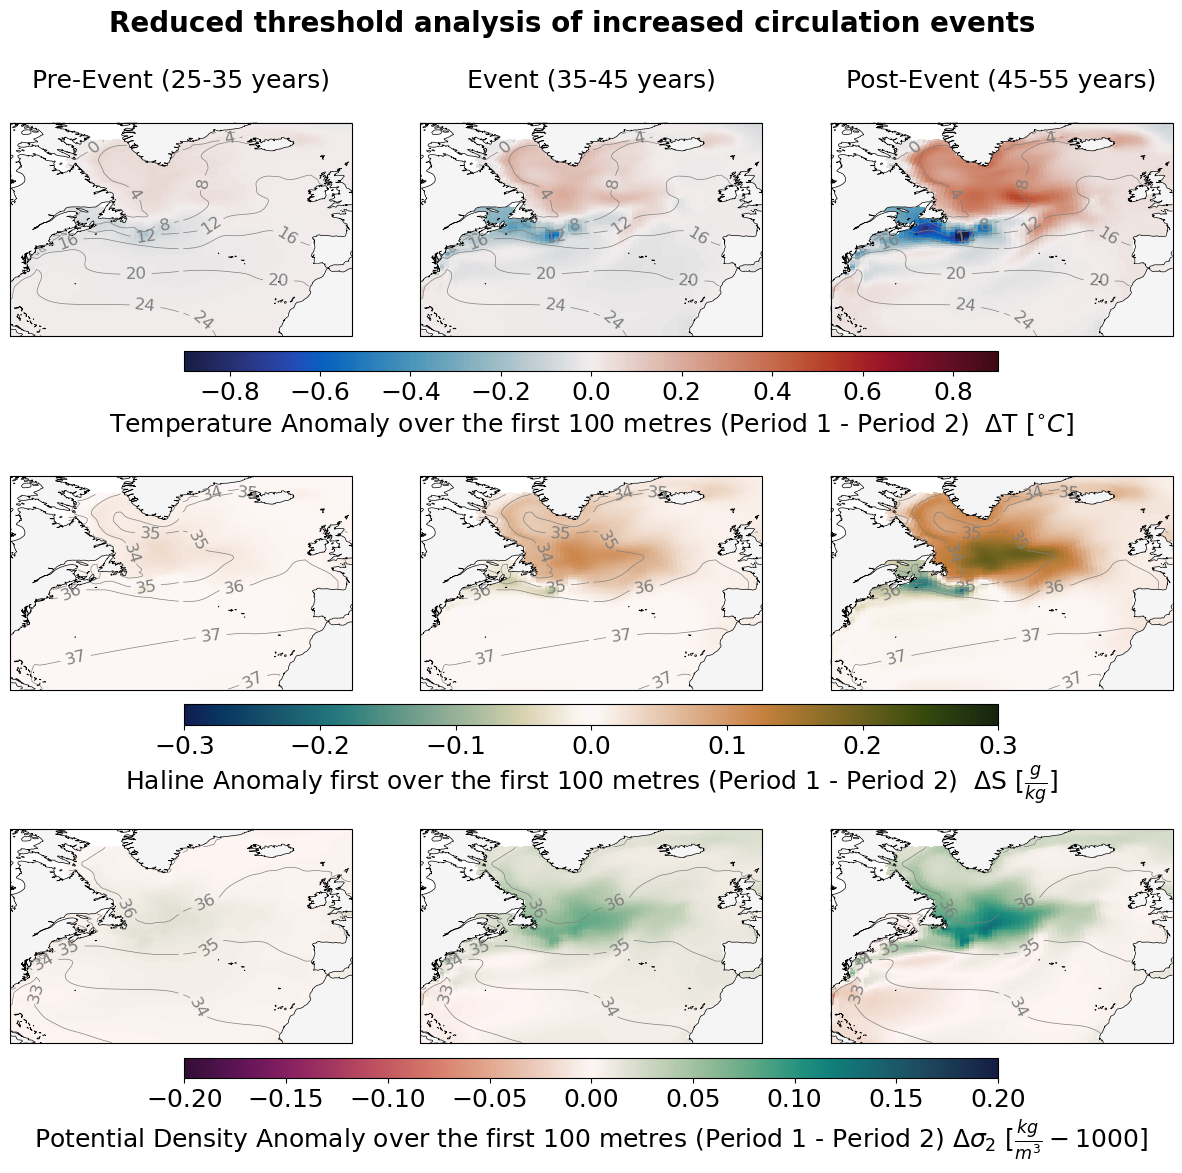

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle('Reduced threshold analysis of increased circulation events', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

plt.show()

# Below

In [11]:
datasets = {var: xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/1_std_' + var + '_below.nc').roll(nlon=+100) for var in variables}
replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

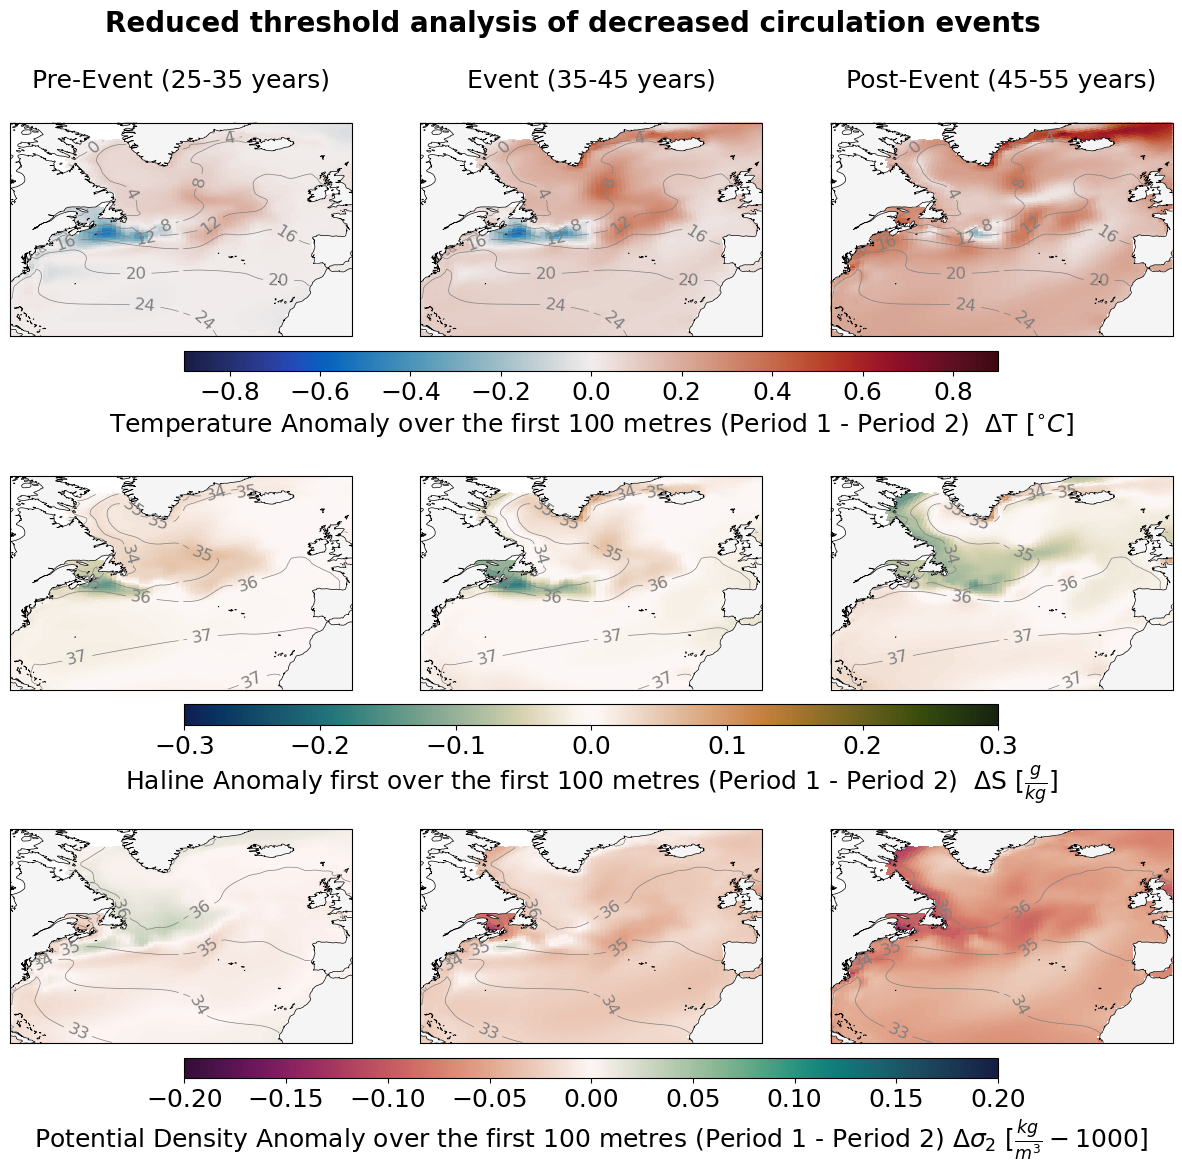

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle('Reduced threshold analysis of decreased circulation events', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

plt.show()